# How Flights Delay?

In this project we explored through our dataset and set up a model predicting delay for given conditions, and based on this model we can give advice on choosing flights on different seasons, airlines and hours. Due to the constraint on difficulties getting whole world delay dataset, and the US is the largest flight country, in our project the delay analysis is mostly based on the US data.

We want to know :
* What will affect mostly on the delay of a flight, could it be departure season, hours or airlines? 
* And can we predict if and how long will a flight delays given certain situations? 
* Or, if some one wants to fly from city A to city B, can we give him or her some advices on choose flights based on the delay rate?

Generally, what we did can be listed as:

1. Data exploration (both 

---
## Table of contents

* [Data Exploration](#Data-Exploration)

    1. [Openflight](#Openflight)
    
    1.1 [Overview of Openflight](#Overview-of-Openflight)
    
    1.2 [Data Analysis for Openflight](#Data-Analysis-for-Openflight)
    
    1.3 [Create and draw graph for Openflight](#Create-and-draw-graph-for-Openflight) In 1.3 we created graph with airports as nodes and distance as weights. And on the spectral graph we can clearly see regional flights are clustered together.
 
    2. [FlightDelay](#Flight-Delay)
    
        2.1 [Overview of Flight Delay](#Overview-of-Flight-Delay)
        
        2.2 [Data Cleaning for Flight Delay](#Data-Cleaning-for-Flight-Delay)
        
        This part is used for data processing before machine learning. We selected flights not cancelled and not diverted and converted data into desired data type.

        2.3 [Data Analysis for Flight Delay](#Data-Analysis-for-Flight-Delay) In 2.3 we analyzed the mean departure and arrival delay on month, departure hour of a day, airlines, departure states and day of a week.
        
        2.4 [Creating features](#Creating-features) 
* [Data Exploitation]

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

import networkx as nx
import missingno as msno

from math import radians,cos,sin,asin,sqrt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

import datetime, warnings, scipy 
import seaborn as sns

---
## Data Exploration

### Openflight
This part is used for data pre-processing and data exploration for the dataset of `OpenFlight` dataset.

In [2]:
routenames = ['Airline', 'Airline_ID', 'Src_IATA', 'Src_ID', 
            'Des_IATA', 'Des_ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv("../routes.dat",header = None,names = routenames,encoding = 'utf-8', na_values='\\N')
routes.dropna(subset=["Airline_ID"], inplace=True)

airlines = pd.read_csv("../airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("../airports.dat",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'], na_values='\\N')

---
### Overview of Openflight

Dataset is obtained from: https://openflights.org/data.html

This OpenFlights/Airline Route Mapper Route Database contains 67,663 routes (EDGES) between 3,321 airports (NODES) on 548 airlines spanning the globe. 

In `routes` data, we have airline, airline ID, source airport IATA code, destination airport IATA code and unique open flight ID, stops and equipment. 

In `airline` data, we have airline ID, airline name, alias, IATA code, ICTO code and country of that airline. 

In `airports` data, we have airport open flight ID, IATA and ICTO code and its latitude and longitude and time zone. Below we use missingno to show the overall data description of each data set.


Below we use `msno` to show the information of dataset. White lines mean missing value. 

In `routes` we have a dataset with size 67184\*9. Columns include airline IATA code, airline unique ID, departure and arrival airport IATA code, code share, stop number of this flight and equipment(the aircraft type).

In [3]:
routes.head(2)

,Airline,Airline_ID,Src_IATA,Src_ID,Des_IATA,Des_ID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2


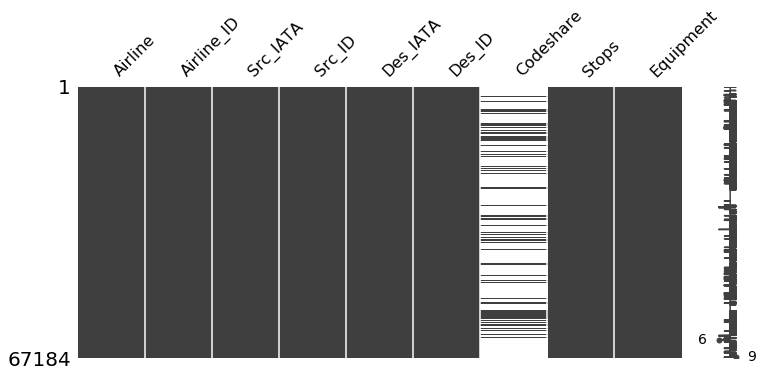

In [4]:
msno.matrix(routes,figsize=(12, 5))#.info()

In `airports` we have a dataset with size 7543\*14. Columns include airport ID, airport name, city, country, IATA and ICAO code of this airport, latitude and longitude, altitude, timezone DST, timezone database, type and data source.

In [5]:
airports.head(2)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ database,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports


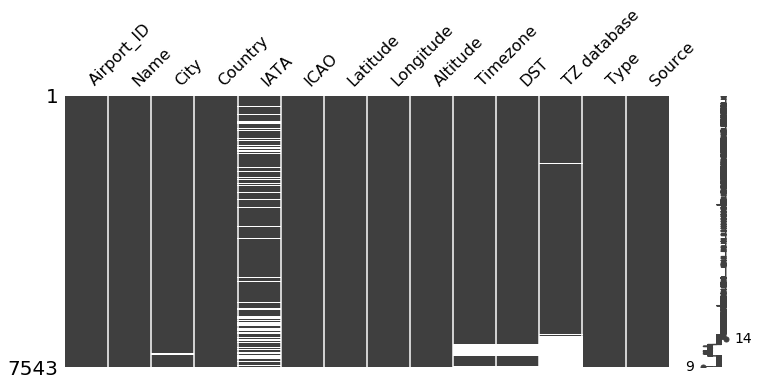

In [6]:
msno.matrix(airports,figsize=(12, 5))#.info()

In `airlines` we have a dataset with size 6162\*8. Columns include airline ID, name, alias, IATA and ICAO code, country and the activeness.

In [7]:
airlines.head(2)

,Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y


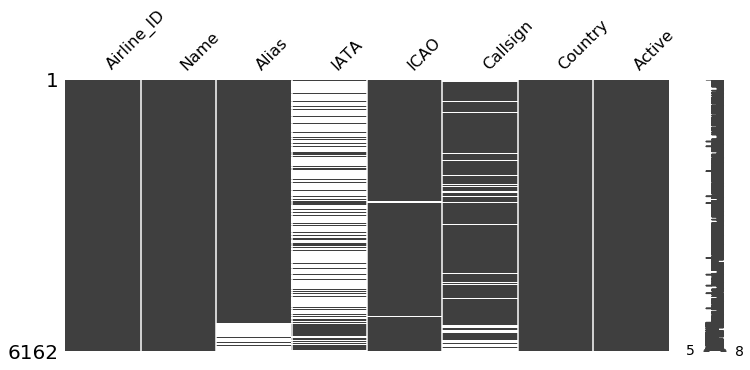

In [8]:
msno.matrix(airlines,figsize=(12, 5))#.info()

---
### Data Analysis for Openflight
In this part we are going to create the adjacency matrix, where the node is airport and the weight of links will be either the routes number between two airports or the maximum capacity of aircrafts on their routes.

In `routes` the column `Equipment` contains the aircraft types of that routes. We calculated the capacity of that route using the maximum of the aircraft capacity. For routes where multi aircrafts are used, we calculated the averaged capacity. And the `Equipment` not in `capacity.xlsx` are mainly helicopters and other small planes, which are not commercially used, so dropping these routes will not affect much.

In [9]:
routes.drop(columns=['Airline','Airline_ID','Codeshare'],inplace=True)
routes.dropna(subset=['Equipment'],inplace=True)
routes.reset_index(level=0, drop=True,inplace=True)

In [10]:
capacity = pd.read_excel('../capacity.xlsx',header=None,index_col=0)
capacity.columns = ['Equipment','Capacity','test']
capacity = capacity[['Equipment','Capacity']]

In [11]:
capacity.dropna(subset=['Capacity'],inplace=True)
capacity.Equipment = capacity.Equipment.astype('str')
capacity.set_index('Equipment',inplace=True)

In [12]:
cap_list = []
for i in range(len(routes)):
    tmp = routes.iloc[i].Equipment#.get_values()
    cap = []
    for equip in tmp.split():
        try:
            cap_tmp = capacity.loc[equip].Capacity
            cap.append(cap_tmp)
        except:
            continue
    cap_list.append(np.mean(cap))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
routes['Capacity'] = cap_list
routes.dropna(subset=['Capacity'],inplace=True)

In [14]:
src_cap = routes[['Src_ID','Capacity']].groupby('Src_ID').sum()
des_cap = routes[['Des_ID','Capacity']].groupby('Des_ID').sum()

In [15]:
# merge the capacity ('src_cap' for departure airport;'des_cap' for destination airport)
src_des_cap = pd.concat([src_cap,des_cap], axis=1, sort=True).fillna(0)
src_des_cap.columns = ['Src_cap','Des_cap']
src_des_cap.reset_index(level=0, inplace=True)
src_des_cap.rename(columns={'index':'Airport_ID'},inplace=True)
src_des_cap.head(2)

,Airport_ID,Src_cap,Des_cap
0,1.0,241.666667,241.666667
1,2.0,540.000000,540.000000


In [16]:
portgeo = pd.DataFrame(pd.concat([routes.Src_ID,routes.Des_ID],axis=0).drop_duplicates())
portgeo.rename(columns={0:'Airport_ID'},inplace=True)
portgeo.reset_index(level=0, drop=True,inplace=True)
portgeo = portgeo.merge(src_des_cap,on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap
0,2965.0,3537.333333,3537.333333
1,2966.0,820.000000,820.000000
2,2968.0,2584.000000,2584.000000
3,4029.0,53273.716667,53408.383333
4,6156.0,843.000000,843.000000


In [17]:
# the final .csv containing latittude, longitude, capcity and node index for each airport
portgeo = portgeo.merge(airports[['Name','City','Country','IATA','Latitude','Longitude','Airport_ID']],on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
0,2965.0,3537.333333,3537.333333,Sochi International Airport,Sochi,Russia,AER,43.449902,39.956600
1,2966.0,820.000000,820.000000,Astrakhan Airport,Astrakhan,Russia,ASF,46.283298,48.006302
2,2968.0,2584.000000,2584.000000,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,55.305801,61.503300
3,4029.0,53273.716667,53408.383333,Domodedovo International Airport,Moscow,Russia,DME,55.408798,37.906300
4,6156.0,843.000000,843.000000,Belgorod International Airport,Belgorod,Russia,EGO,50.643799,36.590099


In [18]:
#portgeo.to_csv('../portgeo.csv',index=False)
portgeo = pd.read_csv('../portgeo.csv')

Here we show the top 10 largest capacity airports. Comparing the list to the real top 10 busiest airports worldwide, we can see that two list overlap a lot.

In [19]:
portgeo.sort_values(by='Src_cap',ascending=False).head(10)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
423,507.0,143397.716667,142622.800000,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941
159,3682.0,141866.095238,139436.509524,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101
266,3364.0,115172.759524,114819.426190,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999
397,1382.0,113329.350000,111403.600000,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000
409,340.0,106306.785714,105942.619048,Frankfurt am Main Airport,Frankfurt,Germany,FRA,50.033333,8.570556
326,3797.0,99766.800000,100187.400000,John F Kennedy International Airport,New York,United States,JFK,40.639801,-73.778900
298,3484.0,95866.950000,96717.783333,Los Angeles International Airport,Los Angeles,United States,LAX,33.942501,-118.407997
242,3930.0,94953.850000,95024.850000,Incheon International Airport,Seoul,South Korea,ICN,37.469101,126.450996
142,3316.0,94079.000000,95077.833333,Singapore Changi Airport,Singapore,Singapore,SIN,1.350190,103.994003
128,3885.0,88661.621429,88772.954762,Suvarnabhumi Airport,Bangkok,Thailand,BKK,13.681100,100.747002


And we can see that the US is the country with largest flight passengers.

In [20]:
portgeo.groupby('Country')['Src_cap','Des_cap'].sum().sort_values(by='Src_cap',ascending=False).head(5)

,Src_cap,Des_cap
Country,,
United States,1.769154e+06,1.767567e+06
China,1.309744e+06,1.309989e+06
United Kingdom,4.779132e+05,4.719609e+05
Spain,4.216310e+05,4.229192e+05
Germany,3.879360e+05,3.858549e+05


---
### Create and draw graph for Openflight
Below we created the graph using airports as nodes, distance of airports as weights.

In [34]:
df_tmp = routes.groupby(['Src_IATA','Des_IATA'])['Capacity'].agg(['count','sum']).reset_index()

In [35]:
df_tmp = df_tmp.merge(portgeo[['IATA','Latitude','Longitude']],left_on='Src_IATA',right_on='IATA').drop(columns='IATA')
df_tmp = df_tmp.merge(portgeo[['IATA','Latitude','Longitude']],\
                      left_on='Des_IATA',right_on='IATA',suffixes=('_Src', '_Des')).drop(columns='IATA')
df_tmp.head()

,Src_IATA,Des_IATA,count,sum,Latitude_Src,Longitude_Src,Latitude_Des,Longitude_Des
0,AAE,ALG,1,124.333333,36.822201,7.809174,36.691002,3.21541
1,ABJ,ALG,1,189.000000,5.261390,-3.926290,36.691002,3.21541
2,ALC,ALG,1,110.000000,38.282200,-0.558156,36.691002,3.21541
3,AMM,ALG,2,247.000000,31.722601,35.993198,36.691002,3.21541
4,AZR,ALG,1,74.000000,27.837601,-0.186414,36.691002,3.21541


We calculated distance using this formula:

$$ S = 2* arcsin\sqrt{sin^2\frac{a}{2}+cos(Lat1)*cos(Lat2)*sin^2\frac{b}{2}} * Earth Radius $$
$$ a = Lat1-Lat2, b = Lon1 - Lon2 $$

In [44]:
def CalDis(point_1_lat, point_1_lon, point_2_lat, point_2_lon):
    # approximate radius of earth in km
    R = 6378.137 # earth radius

    lat1 = radians(float(point_1_lat))
    lon1 = radians(float(point_1_lon))
    lat2 = radians(float(point_2_lat))
    lon2 = radians(float(point_2_lon))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    distance = R * c
    return np.round(distance)

In [54]:
df_tmp['Distance'] = df_tmp.apply(lambda row:CalDis(row['Latitude_Src'],row['Longitude_Src'],
                                                    row['Latitude_Des'],row['Longitude_Des']),axis=1)
df_tmp['Distance'] = df_tmp['Distance'].clip_upper(2000)

In [55]:
# df_tmp.to_csv('LatLonDis.csv',index=False)

In [56]:
df_tmp.head()

,Src_IATA,Des_IATA,count,sum,Latitude_Src,Longitude_Src,Latitude_Des,Longitude_Des,Distance,weight
0,AAE,ALG,1,124.333333,36.822201,7.809174,36.691002,3.21541,410.0,0.996103
1,ABJ,ALG,1,189.000000,5.261390,-3.926290,36.691002,3.21541,2000.0,0.990706
2,ALC,ALG,1,110.000000,38.282200,-0.558156,36.691002,3.21541,377.0,0.996989
3,AMM,ALG,2,247.000000,31.722601,35.993198,36.691002,3.21541,2000.0,0.983935
4,AZR,ALG,1,74.000000,27.837601,-0.186414,36.691002,3.21541,1036.0,0.998711


We first normalized the distance feature and then converted distance to weights with a Gaussian kernel:
$$ W = exp(\frac{Distance^2}{\delta ^2}) $$ 

In [100]:
df_tmp['weight'] = df_tmp['Distance'].copy()
df_tmp.weight=(df_tmp.weight-df_tmp.weight.min())/(df_tmp.weight.max()-df_tmp.weight.min())

delta = 0.2
df_tmp.weight = np.exp(-np.square(df_tmp.weight)/delta)

Then we created our graph with airports as nodes, Gaussian kernel as weights. And we plotted the eigenvalues of our graph, noticing that at 97-th eigenvalue there was a jump. So we performed k-means clustering with k=97 and used the predicted k means result as label over our graph. 

In [101]:
G=nx.from_pandas_edgelist(df_tmp,'Src_IATA','Des_IATA', edge_attr='weight')

In [102]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=100, which='SA')

In [103]:
def NumKMeans(x):
    """
    This function is used to return the index where jump happens.
    """
    x1 = x[:-1]
    x2 = x[1:]
    y = x2 - x1
    return np.argmax(y)+1

In [104]:
n_k_means = NumKMeans(e)
n_k_means

97

Text(0.5,1,'top 100 eigenvalue of our graph')

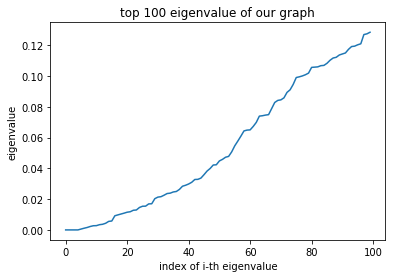

In [105]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 100 eigenvalue of our graph')

In [106]:
X = U[:,0:n_k_means]

k_means = KMeans(init='k-means++', n_clusters=n_k_means, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

Text(0.5,1,'Spectral graph of first and second eigenvectors (zoomed in)')

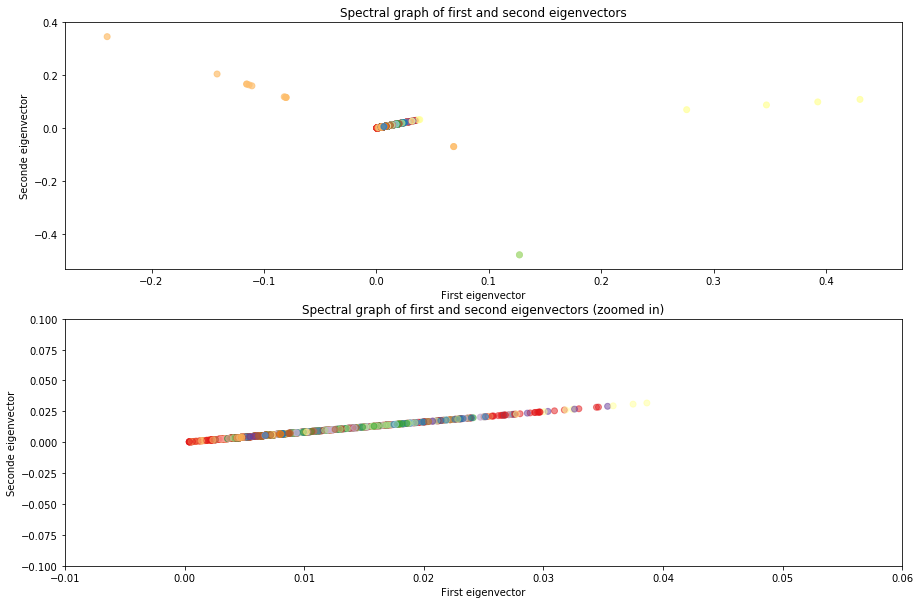

In [108]:
cmap = plt.get_cmap('Paired',n_k_means)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
ax[0].set_title('Spectral graph of first and second eigenvectors')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.5,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.01,0.06)
ax[1].set_ylim(-0.1,0.1)
ax[1].set_title('Spectral graph of first and second eigenvectors (zoomed in)')


The drawing shows that approximately airports are clustered to their neighbourhoods, and we can see the cluster approximately shows the continents and countries ( eg Eastern Asia, Europe, US and Africa).

**We may say that, the world is connected, but it is still separated into small regions.**

In [92]:
pos_dict = {}
portgeo.set_index('IATA',inplace=True)
for node_IATA in list(G.node):
    try:
        longitude = portgeo.loc[node_IATA].Longitude
        latitude = portgeo.loc[node_IATA].Latitude
    except:
        longitude = 0
        latitude = 0        
    pos_dict[node_IATA] = longitude,latitude
portgeo.reset_index(inplace=True)

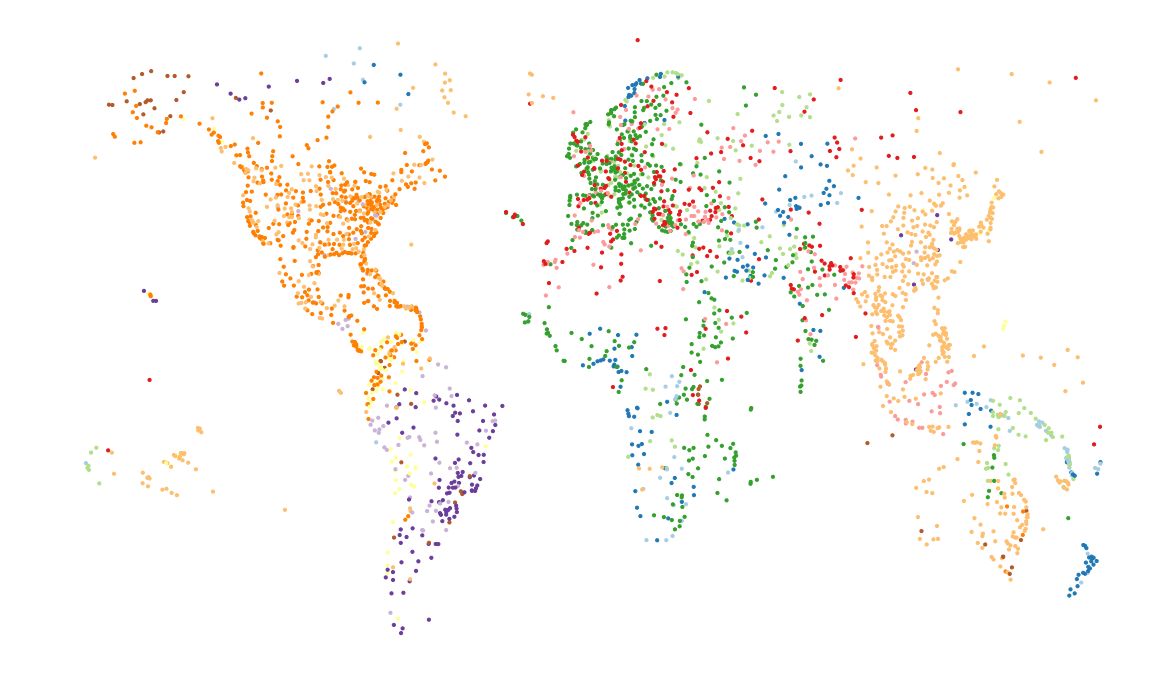

In [99]:
fig, ax = plt.subplots(figsize=(20,12))

nx.draw(G,pos=pos_dict,node_size=10,width=0,node_color=k_means_labels,cmap=cmap)

Go back to [Table of contents](#Table-of-contents)

---
### Flight Delay
This part is for data pre-processing and data exploration for the dataset of `2015 Flight Delays and Cancellations` dataset.

In [2]:
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv',low_memory=False)
#dateCols = ['DATE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DEPARTURE_TIME','ARRIVAL_TIME']
#flights = pd.read_csv('flights_clean.csv',low_memory=False)
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

---
### Overview of Flight Delay

As the US is the busiest country with largest capacity, it is typical to look into details of the US and then apply similar method to other regions.
From Kaggle we downloaded a new dataset containing delay informat ion of US flight routes.

https://www.kaggle.com/usdot/flight-delays#flights.csv

This dataset is collected by the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics, who tracks the on-time performance of domestic flights operated by large air carriers from 01/01/2015 to 31/21/2015. And features information flight number, airline, departure and arrival time, delay time, air time, distance, origin and destination airport and delay reason( not for all delayed flights). Also, the documents including relationship of IATA code and full information of airports and airlines are given. 


`airlines` contains the IATA code and full name of 14 main airports in US.

In [5]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
IATA_CODE    14 non-null object
AIRLINE      14 non-null object
dtypes: object(2)
memory usage: 304.0+ bytes


In [4]:
airlines.head(2)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.


`airports` contains full information of 322 airports (IATA code, airport name, city, state, country, latitude and longitude), and misses three airports' latitude and longitude. After googling we found latitude and longitude of these three airports: ECP 30 -85; PBG 44 -73; UST 29 -81.

In [6]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
IATA_CODE    322 non-null object
AIRPORT      322 non-null object
CITY         322 non-null object
STATE        322 non-null object
COUNTRY      322 non-null object
LATITUDE     319 non-null float64
LONGITUDE    319 non-null float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [16]:
# airports missing latitude and longitude information
airports.loc[airports.LATITUDE.isnull()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [7]:
airports.head(2)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819


In [24]:
# fill in missing value found from google
airports.at[96,'LATITUDE'] = 30
airports.at[96,'LONGITUDE'] = -85
airports.at[234,'LATITUDE'] = 44
airports.at[234,'LONGITUDE'] = -73
airports.at[313,'LATITUDE'] = 29
airports.at[313,'LONGITUDE'] = -81

In [26]:
airports.to_csv('airports.csv',index=False)

Below we use msno to show the information of `flights`. White lines mean Nan value. We can see `flights` has 32 columns and 5714008 samples, columns include flight date, airline, origin and destination airport, flight time information, cancellation and reason and delay reason.

We can see there are large missing values in cancellation and delay reasons, so we are not going to use `reason` as our features in later machine learning part.

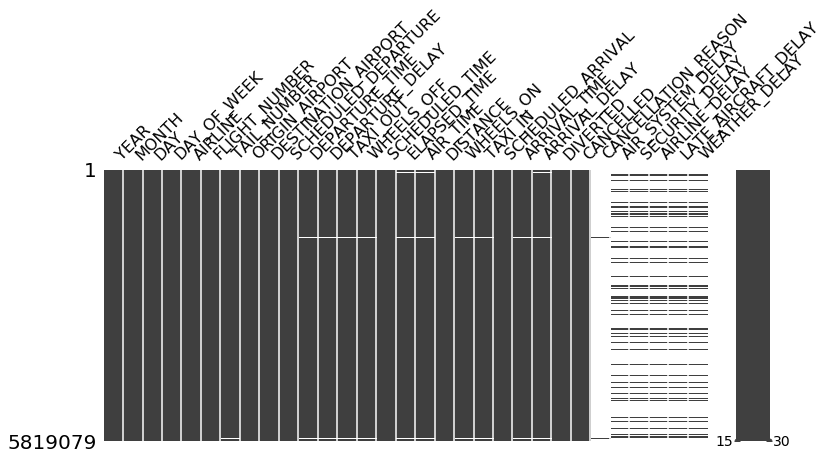

In [14]:
msno.matrix(flights,figsize=(12, 5))#.info()

In [8]:
flights.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01


---
### Data Cleaning for Flight Delay
This part is used for data processing before machine learning. What we did here:

1. First we selected flights not cancelled and not diverted.

2. We noticed in origin dataset, the IATA code of airports in October 2015 is using 5-digit number but not the correct 3-letter code. So we first converted these 5-digit number back to 3-letter IATA code.

3. We converted the time string in original dataset into time.time type;

4. Merging `airport` and flights we merged location of origin and destination airports to each flight.

1. We are not interested in cancelled flights and also, we want to use destination airport as our features, so we do not take diverted flights into account (a diverted flight means the flight does not arrive at the scheduled airport).

In [3]:
flights = flights.loc[flights.CANCELLED==0]
flights = flights.loc[flights.DIVERTED==0]
flights.reset_index(drop=True,inplace=True)

In [4]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

2. Here we converted the 5-digit number in October 2015 into 3-letter IATA code.

In [5]:
df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))

# # Make sure all Origin and departing airports are strings
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)

In [10]:
df = flights.copy()
five_digit = flights.loc[flights.MONTH==10].ORIGIN_AIRPORT.unique()

for i in range(len(five_digit)):
    to_replace = five_digit[i]
    value = aircode_dict[five_digit[i]]
    df.ORIGIN_AIRPORT = df.ORIGIN_AIRPORT.replace(to_replace, value)
    df.DESTINATION_AIRPORT = df.DESTINATION_AIRPORT.replace(to_replace, value)
    print(i,'replaced',to_replace,'with',value)

0 replaced 14747 with SEA
1 replaced 14771 with SFO
2 replaced 12889 with LAS
3 replaced 12892 with LAX
4 replaced 14869 with SLC
5 replaced 10299 with ANC
6 replaced 11292 with DEN
7 replaced 14107 with PHX
8 replaced 11630 with FAI
9 replaced 10732 with BQN
10 replaced 14254 with PSE
11 replaced 10141 with ABR
12 replaced 10627 with BIS
13 replaced 11982 with GRK
14 replaced 12173 with HNL
15 replaced 13930 with ORD
16 replaced 14683 with SAT
17 replaced 12266 with IAH
18 replaced 11618 with EWR
19 replaced 10721 with BOS
20 replaced 13487 with MSP
21 replaced 11884 with GEG
22 replaced 15919 with XNA
23 replaced 13851 with OKC
24 replaced 11111 with COU
25 replaced 10693 with BNA
26 replaced 12191 with HOU
27 replaced 14783 with SGF
28 replaced 15016 with STL
29 replaced 14487 with RDD
30 replaced 10423 with BSM
31 replaced 15370 with TUL
32 replaced 11953 with GNV
33 replaced 13891 with ONT
34 replaced 15376 with TUS
35 replaced 11778 with FSM
36 replaced 11278 with DCA
37 replaced

297 replaced 13541 with MVY
298 replaced 15027 with STX
299 replaced 10170 with ADQ
300 replaced 10165 with ADK
301 replaced 15497 with UST
302 replaced 12265 with IAG
303 replaced 14222 with PPG
304 replaced 14025 with PBG
305 replaced 13502 with MTJ


3. We converted the time string into datetime.time type.

In [13]:
flights = df

In [14]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    return pd.Series(liste)

In [15]:
flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH', 'DAY']])
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(format_heure)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(format_heure)
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(format_heure)
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(format_heure)

In [16]:
# flights.to_csv('flights_clean.csv',index=False)

In [3]:
flights = flights[['DATE','MONTH','DAY','DAY_OF_WEEK',
                  'AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                  'SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DEPARTURE_DELAY','ARRIVAL_DELAY',
                  'AIR_TIME','DISTANCE']]

In [5]:
flights['DATE'] = pd.to_datetime(flights['DATE'])
flights['SCHEDULED_DEPARTURE'] = pd.to_datetime(flights['SCHEDULED_DEPARTURE'],format="%H:%M:%S").dt.time

In [6]:
def hr_func(ts):
    return ts.hour
flights['time_hour'] = flights['SCHEDULED_DEPARTURE'].apply(hr_func)

In [7]:
df = flights.copy()
df_city = df.merge(airports[['IATA_CODE','CITY','STATE']],left_on='ORIGIN_AIRPORT',right_on='IATA_CODE')
df_city.rename(columns={'CITY':'DEPARTURE_CITY','STATE':'DEPARTURE_STATE'},inplace=True)
df_city.drop(columns='IATA_CODE',inplace=True)
df_city = df_city.merge(airports[['IATA_CODE','CITY','STATE']],left_on='DESTINATION_AIRPORT',right_on='IATA_CODE')
df_city.rename(columns={'CITY':'DESTINATION_CITY','STATE':'DESTINATION_STATE'},inplace=True)
df_city.drop(columns='IATA_CODE',inplace=True)
flights = df_city

After all pre-processing we got the data set as below:

In [8]:
# flights.to_csv('flights_new.csv',index=False)
flights.head()

,DATE,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,ARRIVAL_DELAY,AIR_TIME,DISTANCE,time_hour,DEPARTURE_CITY,DEPARTURE_STATE,DESTINATION_CITY,DESTINATION_STATE
0,2015-01-01,1,1,4,AS,98,ANC,SEA,00:05:00,04:30:00,-11.0,-22.0,169.0,1448,0,Anchorage,AK,Seattle,WA
1,2015-01-01,1,1,4,AS,108,ANC,SEA,00:45:00,05:09:00,-4.0,-14.0,173.0,1448,0,Anchorage,AK,Seattle,WA
2,2015-01-01,1,1,4,DL,1560,ANC,SEA,00:45:00,05:15:00,-14.0,-24.0,171.0,1448,0,Anchorage,AK,Seattle,WA
3,2015-01-01,1,1,4,AS,134,ANC,SEA,01:55:00,06:33:00,-15.0,-35.0,170.0,1448,1,Anchorage,AK,Seattle,WA
4,2015-01-01,1,1,4,AS,114,ANC,SEA,02:20:00,06:40:00,-11.0,-12.0,176.0,1448,2,Anchorage,AK,Seattle,WA


---
### Data Analysis for Flight Delay
In this part, we wanted to explore the influence of different features on delay time. We plotted the averaged delay time( both depature delay time and arrival delay time) on each feature:

1. Different airline companies;
2. Day of week (Monday, Tuesday, Wednesday etc.);
3. Month (January, Feburary etc.);
4. Time of a day(from 0 to 23 per hour);
5. Depature city or state.

And we can see that with different airline, day of week, month, time of a day and depature city, the delay time differs. And generally, the arrival delay time would be shorter than departure delay time, which means the airline will speed up a little to counterback depacture delay. 

1. First we looked at the averaged delay time of different airline. Generally Hawaiian Airlines and Alaska Airlines have lowest delay time. And when we considered the counts of delay flights (here we used 5 and 30 minutes thresholding not delay, small delay and heavy delay). And we can see Southwest airline serves most flights and also most delays; Hawaiian airline serves least flights and thus least delays.

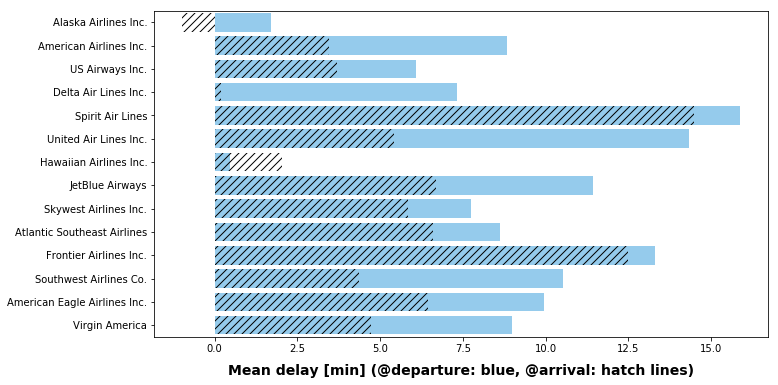

In [10]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);


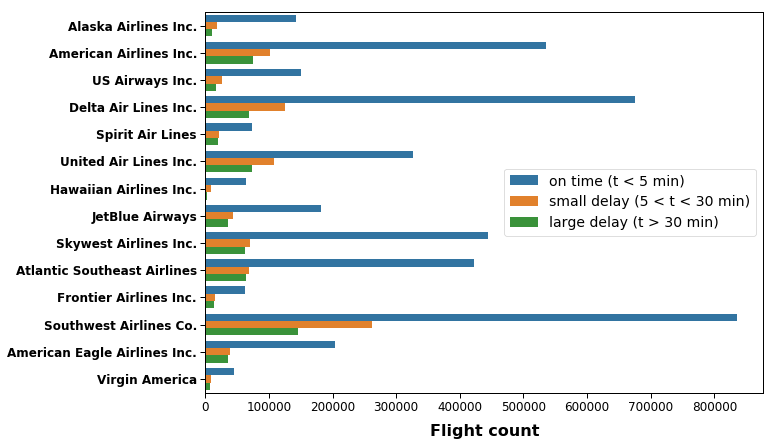

In [53]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 30]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 30 min)')
L.get_texts()[2].set_text('large delay (t > 30 min)')
plt.show()

2. To see if the day of week of a flight will influence the delay time. And we can see that Monday has longest averaged delay and Saturday the shortest.

In [48]:
week_dict = {'1':'Monday','2':"Tuesday",'3':'Wednesday','4':'Thursday','5':'Friday',
            '6':'Saturday','7':'Sunday'}

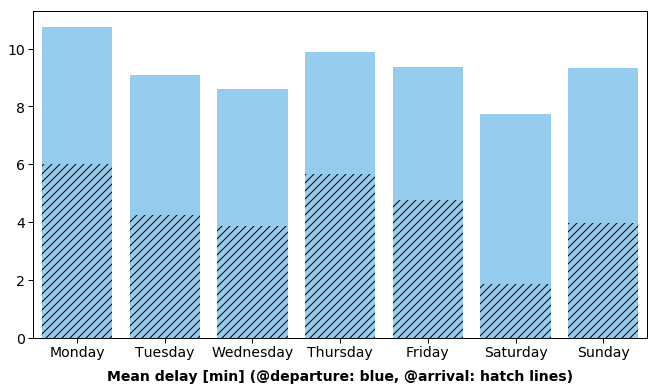

In [51]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="DAY_OF_WEEK", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="DAY_OF_WEEK", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [week_dict[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);


3. Next we plotted averaged delay time of different month. Generally, there is a fluctuation in season (spring and autumn(Feburary, March, April and September, October, November) have shorter delay time while rest have longer time). And June and December have highest delay time, which may be explained by summer holiday and Christmas.

In [56]:
month_dict = {'1':'Jan','2':"Feb",'3':'Mar','4':'Apr','5':'May',
            '6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct',
             '11':'Nov','12':'Dec'}

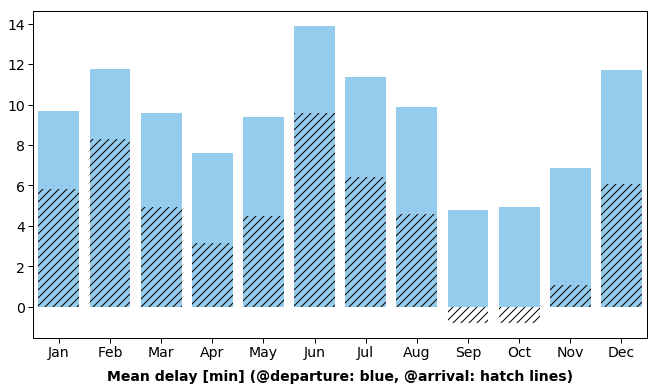

In [57]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="MONTH", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="MONTH", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [month_dict[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);


4. Next we plotted the delay time differences of different departure city/state. Because there are too many cities, for the sake of clearness, here we just plotted top 15 busiest cities and their averaged delay time.

In [44]:
city_names = df_city.DEPARTURE_CITY.value_counts().head(15).index
city_names

Index(['Chicago', 'Atlanta', 'Dallas-Fort Worth', 'Houston', 'Denver',
       'Los Angeles', 'New York', 'San Francisco', 'Phoenix', 'Las Vegas',
       'Minneapolis', 'Seattle', 'Orlando', 'Detroit', 'Boston'],
      dtype='object')

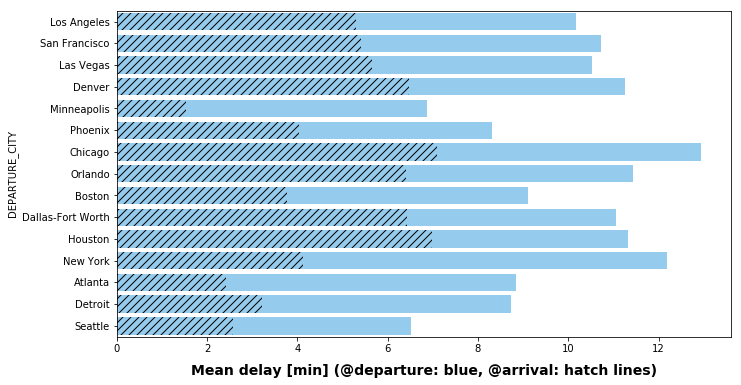

In [43]:
df = df_city[df_city['DEPARTURE_CITY'].isin(city_names)]
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="DEPARTURE_CITY", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="DEPARTURE_CITY", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

And we showed the delay time differences in all US states.

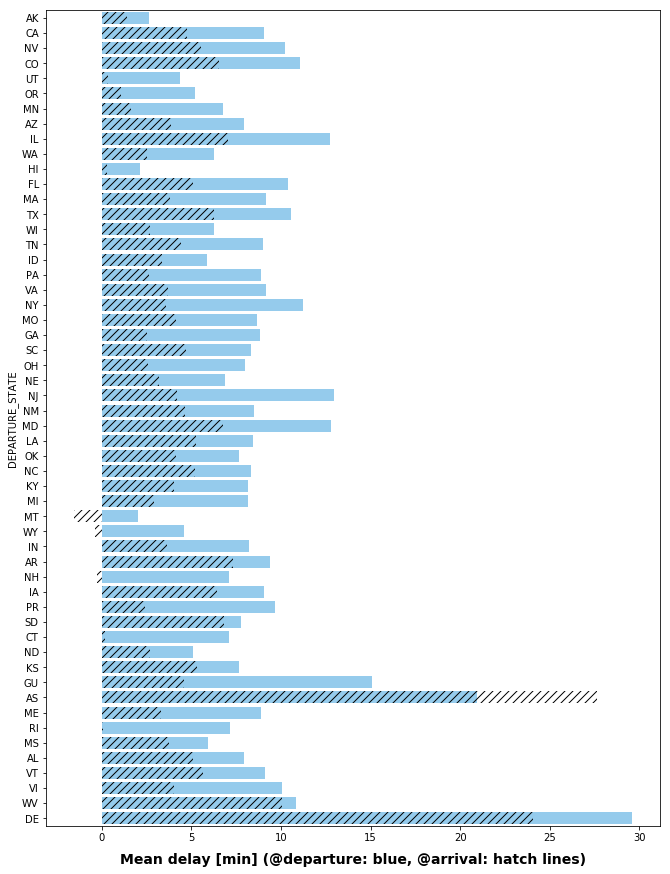

In [15]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,15))
ax = sns.barplot(x="DEPARTURE_DELAY", y="DEPARTURE_STATE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="DEPARTURE_STATE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
# labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
# ax.set_yticklabels(labels)
# ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

5. Finally, we plotted the delay time over time of a day. And it is interesting that the delay time grows gradually after 5 am and slowly drops after 20pm. It reflects with the reality, that morning flights are less likely to be delayed, while later flights, because of delay of former flights, will be more likely to be delayed.

In [68]:
def hr_func(ts):
    return ts.hour
df['time_hour'] = df['SCHEDULED_DEPARTURE'].apply(hr_func)

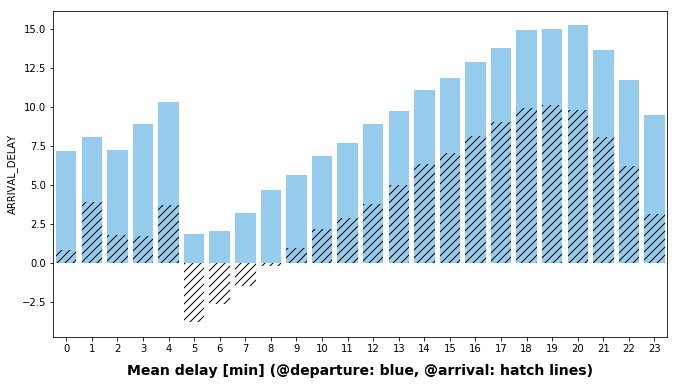

In [71]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="time_hour", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="time_hour", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
# labels = [month_dict[item.get_text()] for item in ax.get_xticklabels()]
# ax.set_xticklabels(labels)
# ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

Also, we noticed that different airlines have their preferred cities, which incide with their focus cities.

In [34]:
# HA for Hawaiian Airlines Inc.
flights.loc[flights.AIRLINE=='HA'].DEPARTURE_CITY.value_counts().head()

Honolulu       32828
Kahului        14014
Kailua/Kona     7939
Lihue           7884
Hilo            5932
Name: DEPARTURE_CITY, dtype: int64

In [33]:
# WN for Southwest Airlines Co.
flights.loc[flights.AIRLINE=='WN'].DEPARTURE_CITY.value_counts().head()

Chicago      81364
Las Vegas    74226
Baltimore    68427
Denver       60278
Phoenix      58010
Name: DEPARTURE_CITY, dtype: int64

---
### Creating features 
Next, we will use the features above in our machine learning part. As we can see most of the features (monty, day of week, airline, departure state) are categorical data and we need to use one hot to encode these features.

In [17]:
month_feature = pd.get_dummies(flights.MONTH,prefix='Month',sparse=True)
hour_feature = pd.get_dummies(flights.time_hour,prefix='Hour',sparse=True)
org_airport = pd.get_dummies(flights.ORIGIN_AIRPORT,prefix='Org',sparse=True)
des_airport = pd.get_dummies(flights.DESTINATION_AIRPORT,prefix='Des',sparse=True)
airline_feature = pd.get_dummies(flights.AIRLINE,sparse=True)
day_of_week_feature = pd.get_dummies(flights.DAY_OF_WEEK,prefix='week',sparse=True)

In [19]:
df = pd.concat([month_feature,hour_feature,org_airport,des_airport,airline_feature,day_of_week_feature], axis=1)

In [20]:
numeric_feature = flights[['AIR_TIME','DISTANCE']]

In [21]:
df = pd.concat([df,numeric_feature],axis=1)

In [28]:
delay = flights[['DEPARTURE_DELAY','ARRIVAL_DELAY']]
df = pd.concat([df,delay],axis=1)